Loaded dataset: shape=(1858, 31), columns=['Close', 'High', 'Low', 'Open', 'Volume', 'log_ret', 'vol_band', 'hv10', 'hv20', 'hv30', 'hv10_z', 'hv30_z', 'hv10_fwd', 'hv20_fwd', 'hv30_fwd', 'abs_log_ret', 'abs_log_ret_lag1', 'abs_log_ret_lag5', 'ret_3d', 'ret_std_5d', 'hv_diff', 'day_of_week', 'days_to_expiry', 'abs_log_ret_z', 'abs_log_ret_lag1_z', 'abs_log_ret_lag5_z', 'ret_3d_z', 'ret_std_5d_z', 'hv20_z', 'hv_diff_z', 'days_to_expiry_z']
After dropping NaNs: shape=(1829, 31)


/tmp/ipykernel_7850/2023804607.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model[f"y_pred_{name}"] = np.nan
/tmp/ipykernel_7850/2023804607.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model[f"y_pred_{name}"] = np.nan
/tmp/ipykernel_7850/2023804607.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/us


=== Model Performance ===
RF -> In R²: 0.7878 | OOS R²: -2.3355 | OOS RMSE: 0.11941
XGB -> In R²: 0.9430 | OOS R²: -1.0161 | OOS RMSE: 0.09283
GB -> In R²: 0.8772 | OOS R²: -0.8651 | OOS RMSE: 0.08929

Best model by OOS R²: GB
✅ Saved predictions to data/processed/underlying_price_with_preds.pkl


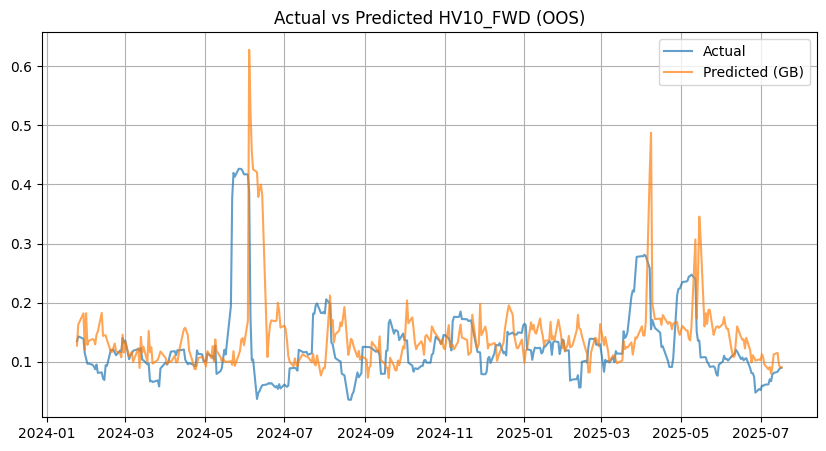

In [1]:
# phase3_model_training.py

import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

# Sklearn models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

# XGBoost
from xgboost import XGBRegressor

# ======================
# 1. Load dataset
# ======================
DATA_PATH = Path("data/processed/underlying_price.pkl")
if not DATA_PATH.exists():
    raise FileNotFoundError(f"{DATA_PATH} not found. Run Phase 2 first.")

df = pd.read_pickle(DATA_PATH)
print(f"Loaded dataset: shape={df.shape}, columns={list(df.columns)}")

# ======================
# 2. Define features & target
# ======================
# Using only z-scored features to avoid scaling issues across models
features = [c for c in df.columns if c.endswith("_z")]
target = "hv10_fwd"

df_model = df.dropna(subset=features + [target])
print(f"After dropping NaNs: shape={df_model.shape}")

# Train/test split (80/20 by time)
split_idx = int(0.8 * len(df_model))
train_df = df_model.iloc[:split_idx]
test_df = df_model.iloc[split_idx:]

X_train, y_train = train_df[features], train_df[target]
X_test, y_test = test_df[features], test_df[target]

# ======================
# 3. Train models
# ======================

models = {
    "rf": RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42),
    "xgb": XGBRegressor(n_estimators=300, max_depth=4, learning_rate=0.05,
                        subsample=0.8, colsample_bytree=0.8, random_state=42),
    "gb": GradientBoostingRegressor(n_estimators=200, max_depth=3,
                                    learning_rate=0.05, random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    in_r2 = r2_score(y_train, y_pred_train)
    oos_r2 = r2_score(y_test, y_pred_test)
    oos_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

    results[name] = {"in_r2": in_r2, "oos_r2": oos_r2, "oos_rmse": oos_rmse}

    # Save predictions to main df
    df_model[f"y_pred_{name}"] = np.nan
    df_model.loc[train_df.index, f"y_pred_{name}"] = y_pred_train
    df_model.loc[test_df.index, f"y_pred_{name}"] = y_pred_test

# ======================
# 4. Print model metrics
# ======================
print("\n=== Model Performance ===")
for name, metrics in results.items():
    print(f"{name.upper()} -> In R²: {metrics['in_r2']:.4f} | OOS R²: {metrics['oos_r2']:.4f} | OOS RMSE: {metrics['oos_rmse']:.5f}")

# ======================
# 5. Pick best model and set as y_pred
# ======================
best_model = max(results.items(), key=lambda kv: kv[1]['oos_r2'])[0]
print(f"\nBest model by OOS R²: {best_model.upper()}")
df_model["y_pred"] = df_model[f"y_pred_{best_model}"]

# ======================
# 6. Merge back into full df & save
# ======================
df_full = df.copy()
for col in df_model.columns:
    if col.startswith("y_pred"):
        df_full[col] = df_model[col]

df_full.to_pickle("data/processed/underlying_price_with_preds.pkl")
print("✅ Saved predictions to data/processed/underlying_price_with_preds.pkl")

# ======================
# 7. Plot actual vs predicted (best model)
# ======================
plt.figure(figsize=(10, 5))
plt.plot(test_df.index, y_test, label="Actual", alpha=0.7)
plt.plot(test_df.index, df_model.loc[test_df.index, "y_pred"], label=f"Predicted ({best_model.upper()})", alpha=0.7)
plt.title("Actual vs Predicted HV10_FWD (OOS)")
plt.legend()
plt.grid(True)
plt.show()



